# Gumbel Softmax / Concrete VAE with BayesFlow

Implements a categorical VAE using the technique introduced in [The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables (Maddison et al. 2016)](https://arxiv.org/abs/1611.00712) and [Categorical Reparameterization with Gumbel-Softmax (Jang et al. 2016)](https://arxiv.org/abs/1611.01144). The VAE architecture shown here are a bit different than the models presented in the papers, this one has 1 stochastic 20x10-ary layer with 2-layer deterministic encoder/decoders and a fixed prior.

17 Feb 2017

In [1]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.examples.tutorials.mnist import input_data

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# slim=tf.contrib.slim
import tf_slim as slim

# Bernoulli = tf.contrib.distributions.Bernoulli
# OneHotCategorical = tf.contrib.distributions.OneHotCategorical
# RelaxedOneHotCategorical = tf.contrib.distributions.RelaxedOneHotCategorical

import tensorflow_probability as tfp
Bernoulli = tfp.distributions.Bernoulli
OneHotCategorical = tfp.distributions.OneHotCategorical
RelaxedOneHotCategorical = tfp.distributions.RelaxedOneHotCategorical

In [3]:
# black-on-white MNIST (harder to learn than white-on-black MNIST)
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

from tensorflow import keras

# load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("Training data x_train shape:", x_train.shape)
print("Training data y_train shape:", y_train.shape)

print("Training data x_train shape:", x_test.shape)
print("Training data y_train shape:", y_test.shape)

# print("Training data x_train[0]:", x_train[0])
print("Training data y_train[0]:", y_train[0])

# preprocess
# x_train = x_train.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print("Training data x_train shape:", x_train.shape)
print("Training data y_train shape:", y_train.shape)

print("Training data x_train shape:", x_test.shape)
print("Training data y_train shape:", y_test.shape)

# print("Training data x_train[0]:", x_train[0])
print("Training data y_train[0]:", y_train[0])


Training data x_train shape: (60000, 28, 28)
Training data y_train shape: (60000,)
Training data x_train shape: (10000, 28, 28)
Training data y_train shape: (10000,)
Training data y_train[0]: 5
Training data x_train shape: (60000, 28, 28)
Training data y_train shape: (60000, 10)
Training data x_train shape: (10000, 28, 28)
Training data y_train shape: (10000, 10)
Training data y_train[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [4]:

from tensorflow.python.framework import dtypes

# copied from: https://github.com/tensorflow/tensorflow/blob/v0.10.0/tensorflow/contrib/learn/python/learn/datasets/mnist.py
class DataSet(object):

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        # assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in range(batch_size)], [
          fake_label for _ in range(batch_size)
      ]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]

mnist_train = DataSet(x_train, y_train, one_hot=True)
mnist_test = DataSet(x_test, y_test, one_hot=True)

In [5]:
batch_size=100
tau0=1.0 # initial temperature
K=10 # number of classes
N=200//K # number of categorical distributions
straight_through=False # if True, use Straight-through Gumbel-Softmax
kl_type='relaxed' # choose between ('relaxed', 'categorical')
learn_temp=False 

In [6]:
x=tf.placeholder(tf.float32, shape=(batch_size,784), name='x')
net = tf.cast(tf.random_uniform(tf.shape(x)) < x, x.dtype) # dynamic binarization
net = slim.stack(net,slim.fully_connected,[512,256])
logits_y = tf.reshape(slim.fully_connected(net,K*N,activation_fn=None),[-1,N,K])
tau = tf.Variable(tau0,name="temperature",trainable=learn_temp)
q_y = RelaxedOneHotCategorical(tau,logits_y)
y = q_y.sample()
if straight_through:
  y_hard = tf.cast(tf.one_hot(tf.argmax(y,-1),K), y.dtype)
  y = tf.stop_gradient(y_hard - y) + y
net = slim.flatten(y)
net = slim.stack(net,slim.fully_connected,[256,512])
logits_x = slim.fully_connected(net,784,activation_fn=None)
p_x = Bernoulli(logits=logits_x)
x_mean = p_x.mean()

/opt/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/opt/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


In [7]:
recons = tf.reduce_sum(p_x.log_prob(x),1)
logits_py = tf.ones_like(logits_y) * 1./K

if kl_type=='categorical' or straight_through:
  # Analytical KL with Categorical prior
  p_cat_y = OneHotCategorical(logits=logits_py)
  q_cat_y = OneHotCategorical(logits=logits_y)
  KL_qp = tf.contrib.distributions.kl(q_cat_y, p_cat_y)
else:
  # Monte Carlo KL with Relaxed prior
  p_y = RelaxedOneHotCategorical(tau,logits=logits_py)
  KL_qp = q_y.log_prob(y) - p_y.log_prob(y)


In [8]:
KL = tf.reduce_sum(KL_qp,1)
mean_recons = tf.reduce_mean(recons)
mean_KL = tf.reduce_mean(KL)
loss = -tf.reduce_mean(recons-KL)


In [9]:
train_op=tf.train.AdamOptimizer(learning_rate=3e-4).minimize(loss)

In [10]:
data = []
with tf.train.MonitoredSession() as sess:
  for i in range(1,50000):
    batch = mnist_train.next_batch(batch_size)
    res = sess.run([train_op, loss, tau, mean_recons, mean_KL], {x : batch[0]})
    if i % 100 == 1:
      data.append([i] + res[1:])
    if i % 1000 == 1:
      print('Step %d, Loss: %0.3f' % (i,res[1]))
  # end training - do an eval
  batch = mnist_test.next_batch(batch_size)
  np_x = sess.run(x_mean, {x : batch[0]})

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Step 1, Loss: 564.390
Step 1001, Loss: 213.598
Step 2001, Loss: 204.496
Step 3001, Loss: 198.617
Step 4001, Loss: 190.896
Step 5001, Loss: 271.380
Step 6001, Loss: 667.479
Step 7001, Loss: 669.510
Step 8001, Loss: 754.136
Step 9001, Loss: 878.596
Step 10001, Loss: 1238.788
Step 11001, Loss: 1951.368
Step 12001, Loss: 4428.485
Step 13001, Loss: 3908.028
Step 14001, Loss: 4214.109
Step 15001, Loss: 11539.069
Step 16001, Loss: 8581.658
Step 17001, Loss: 9256.613
Step 18001, Loss: 8535.355
Step 19001, Loss: 12294.903
Step 20001, Loss: 13133.564
Step 21001, Loss: 18196.289
Step 22001, Loss: 21204.189
Step 23001, Loss: 31684.590
Step 24001, Loss: 24596.520
Step 25001, Loss: 28291.648
Step 26001, Loss: 35961.145
Step 27001, Loss: 34956.195
Step 28001, Loss: 34560.016
Step 29001, Loss: 36959.574
Step 30001, Loss: 44700.500
Step 31001, Loss: 50489.230
Step 32001, Loss: 53659.2

In [11]:
data = np.array(data).T

Text(0.5, 1.0, 'KL')

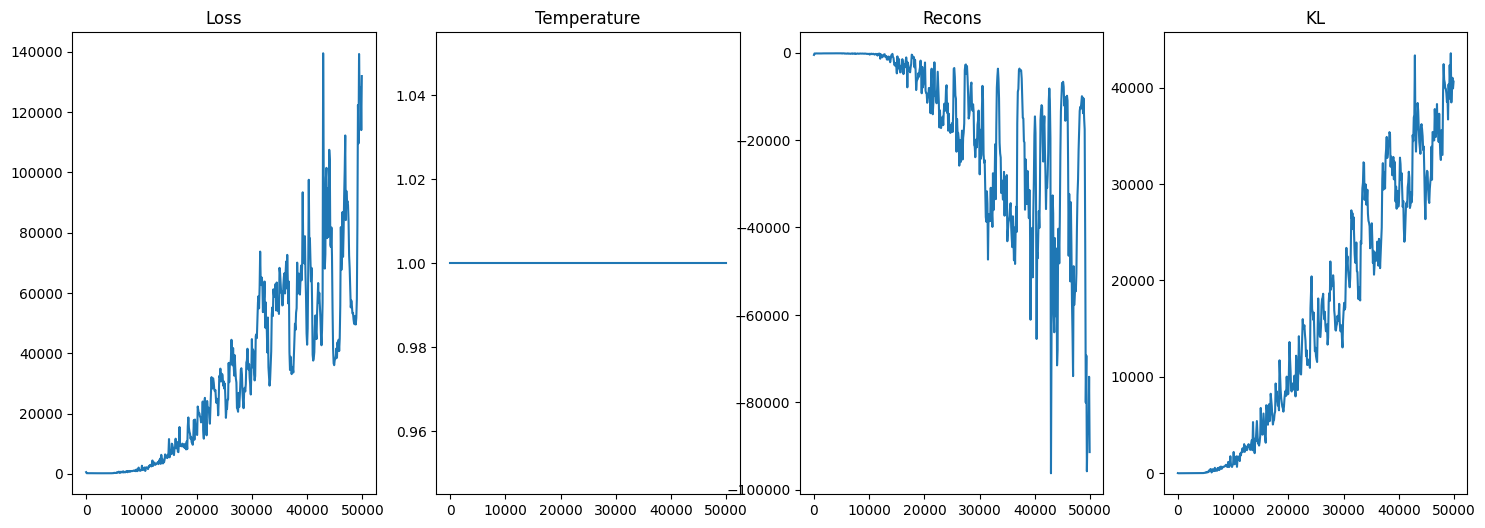

In [12]:
f,axarr=plt.subplots(1,4,figsize=(18,6))
axarr[0].plot(data[0],data[1])
axarr[0].set_title('Loss')

axarr[1].plot(data[0],data[2])
axarr[1].set_title('Temperature')

axarr[2].plot(data[0],data[3])
axarr[2].set_title('Recons')

axarr[3].plot(data[0],data[4])
axarr[3].set_title('KL')

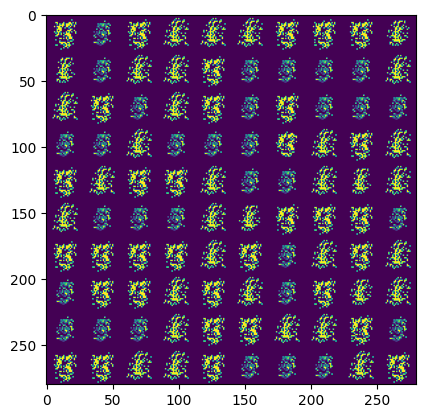

In [15]:
tmp = np.reshape(np_x,(-1,280,28)) # (10,280,28)
img = np.hstack([tmp[i] for i in range(10)])
plt.imshow(img)
plt.grid(False)